<a href="https://colab.research.google.com/github/iscel15/Data-Science-Projects/blob/main/An%C3%A1lisis%20de%20W%20Comae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


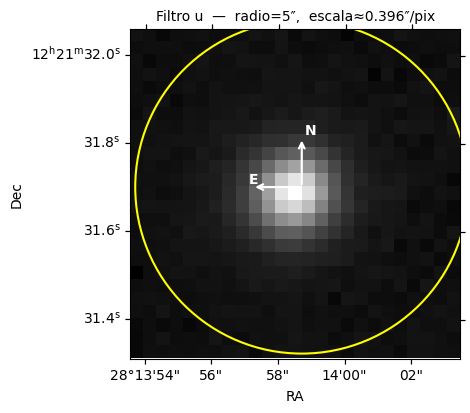

✓ Guardados: WComae_u.fits  y  WComae_u.png  |  λ_c ≈ 355.1 nm


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


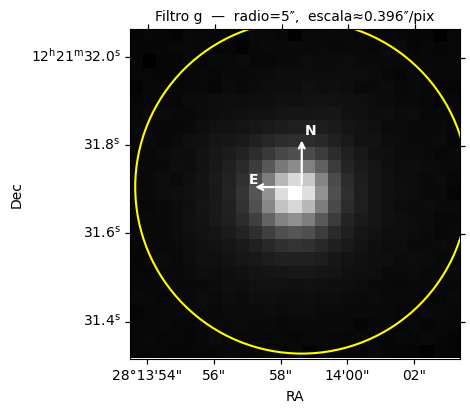

✓ Guardados: WComae_g.fits  y  WComae_g.png  |  λ_c ≈ 468.6 nm


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


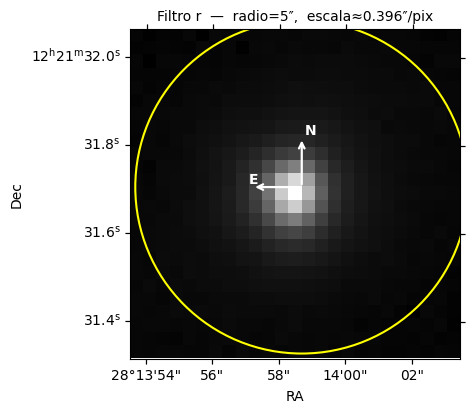

✓ Guardados: WComae_r.fits  y  WComae_r.png  |  λ_c ≈ 616.5 nm


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


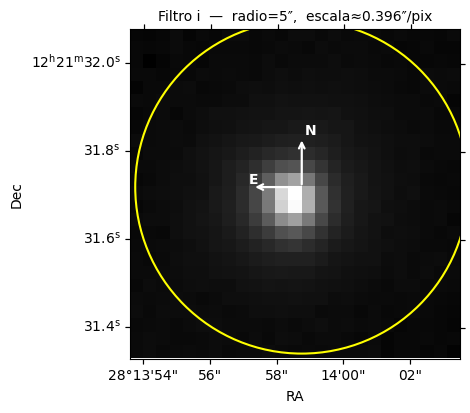

✓ Guardados: WComae_i.fits  y  WComae_i.png  |  λ_c ≈ 748.1 nm


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.


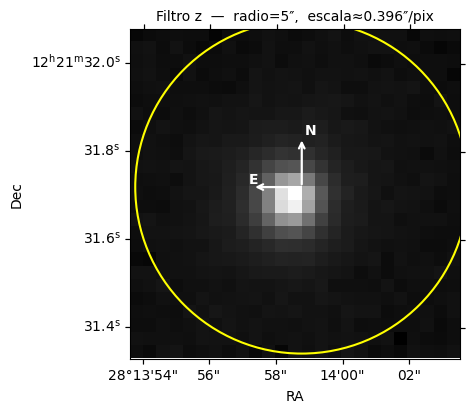

✓ Guardados: WComae_z.fits  y  WComae_z.png  |  λ_c ≈ 893.1 nm

Longitudes de onda centrales (nm):
  u: 355.1
  g: 468.6
  r: 616.5
  i: 748.1
  z: 893.1

Archivos en: /content/sdss_WComae


In [14]:
# pip install astroquery astropy numpy matplotlib

from astroquery.sdss import SDSS
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy.visualization import simple_norm
from astropy import units as u

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from pathlib import Path
import warnings

# Opcional: silenciar warnings de FITS/WCS
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# -------------------------------------------------
# Coordenadas de W Comae (ajusta si usas otras)
# -------------------------------------------------
ra  = 185.382049   # deg
dec =  28.232894   # deg
pos = SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame="icrs")

# -------------------------------------------------
# Filtros y longitudes de onda centrales (nm)
# -------------------------------------------------
filtros = ["u", "g", "r", "i", "z"]
lambda_central_nm = {"u":355.1, "g":468.6, "r":616.5, "i":748.1, "z":893.1}

# Radio de la región circular (5″)
radio = 5.0 * u.arcsec

# Carpeta de salida
outdir = Path("sdss_WComae")
outdir.mkdir(exist_ok=True)

def descargar_recortar_guardar(filtro: str):
    # 1) Descargar el frame de SDSS (tu astroquery acepta 'coordinates' y 'band')
    imgs = SDSS.get_images(coordinates=pos, band=filtro)
    if not imgs:
        print(f"⚠ No se encontró FITS para filtro {filtro}")
        return

    hdu = imgs[0][0]      # Primary HDU con data + header
    wcs = WCS(hdu.header)

    # 2) Recorte cuadrado de diámetro 2*radio (equivale a 5″ de radio)
    cut = Cutout2D(hdu.data, position=pos, size=2*radio, wcs=wcs)
    # ✅ conserva el header original y añade el WCS del recorte
    new_header = hdu.header.copy()          # mantiene NMGY, BUNIT, etc.
    new_header.update(cut.wcs.to_header())  # añade/actualiza claves WCS
    cut_hdu = fits.PrimaryHDU(data=cut.data, header=new_header)


    # 3) Guardar FITS recortado
    fits_path = outdir / f"WComae_{filtro}.fits"
    cut_hdu.writeto(fits_path, overwrite=True)

    # 4) Escala (arcsec/pixel) para anotar y calcular círculo de 5″
    pix_scales_deg = proj_plane_pixel_scales(cut.wcs)     # deg/pixel (dy, dx)
    pixscale_as = float(np.mean(pix_scales_deg) * 3600.0) # ″/pixel
    radio_pix = (radio.to(u.arcsec).value) / pixscale_as

    # 5) Figura con WCS, círculo 5″, N/E y escala
    fig = plt.figure(figsize=(4.8, 4.8))
    ax  = plt.subplot(projection=cut.wcs)

    # Usa SOLO 'norm'
    norm = simple_norm(cut.data, stretch="sqrt")
    ax.imshow(cut.data, origin="lower", cmap="gray", norm=norm)

    ax.set_xlabel("RA"); ax.set_ylabel("Dec")
    ax.set_title(f"Filtro {filtro}  —  radio=5″,  escala≈{pixscale_as:.3f}″/pix", fontsize=10)

    ny, nx = cut.data.shape
    cx, cy = nx/2.0, ny/2.0

    # Círculo de 5″ centrado
    circ = Circle((cx, cy), radius=radio_pix, fill=False, ec="yellow", lw=1.5)
    ax.add_patch(circ)

    # Flechas N y E
    ax.annotate("", xy=(cx, cy+ny*0.15), xytext=(cx, cy),
                arrowprops=dict(arrowstyle="->", lw=1.6, color="white"))
    ax.text(cx+nx*0.01, cy+ny*0.16, "N", color="white", weight="bold")
    ax.annotate("", xy=(cx-nx*0.15, cy), xytext=(cx, cy),
                arrowprops=dict(arrowstyle="->", lw=1.6, color="white"))
    ax.text(cx-nx*0.16, cy+ny*0.01, "E", color="white", weight="bold")

    plt.tight_layout()
    png_path = outdir / f"WComae_{filtro}.png"
    plt.savefig(png_path, dpi=200)
    plt.show()

    print(f"✓ Guardados: {fits_path.name}  y  {png_path.name}  |  λ_c ≈ {lambda_central_nm[filtro]} nm")

# Ejecutar para cada filtro
for f in filtros:
    descargar_recortar_guardar(f)

print("\nLongitudes de onda centrales (nm):")
for f in filtros:
    print(f"  {f}: {lambda_central_nm[f]}")
print(f"\nArchivos en: {outdir.resolve()}")


In [15]:
!pip install photutils --quiet

from photutils.aperture import CircularAperture, aperture_photometry


# -----------------------------
# Entradas
# -----------------------------
# Carpeta donde  se guardaron los recortes FITS :
indir = Path("sdss_WComae")

# Coordenadas
pos = SkyCoord(185.382049*u.deg, 28.232894*u.deg, frame="icrs")

# Radio de la apertura: 5 arcsec
radius = 5.0 * u.arcsec

# Longitudes de onda centrales (nm) para u,g,r,i,z
lambda_nm = {"u":355.1, "g":468.6, "r":616.5, "i":748.1, "z":893.1}
bands = ["u","g","r","i","z"]

# Conversión: 1 nanomaggie a cgs en F_nu (erg s^-1 cm^-2 Hz^-1)
NMAGGY_TO_CGS = 3.631e-29   # (3631 Jy × 1e-9 × 1e-23)

c = 2.99792458e10  # cm/s

def fnu_to_flambda(Fnu_cgs, lambda_nm_value):
    """F_lambda (erg s^-1 cm^-2 Å^-1) desde F_nu, usando lambda central."""
    lam_cm = (lambda_nm_value*1e-7)  # nm -> cm
    Flambda_cgs_per_cm = Fnu_cgs * c / (lam_cm**2)  # erg s^-1 cm^-2 cm^-1
    # convertir a por Å (1 Å = 1e-8 cm) => dividir por 1e8
    return Flambda_cgs_per_cm / 1e8

def flujo_en_apertura(fits_path, skycoord, radius_arcsec):
    """Devuelve suma en counts, en nanomaggies, Fnu (cgs) y Flambda (cgs/Å)."""
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs  = WCS(hdu.header)

    # Centro en pixeles y escala
    x, y = wcs.world_to_pixel(skycoord)
    pix_scale_deg = np.mean(proj_plane_pixel_scales(wcs))   # deg/pix
    pix_scale_as  = pix_scale_deg * 3600.0                  # arcsec/pix
    r_pix = (radius_arcsec.to_value(u.arcsec)) / pix_scale_as

    # Apertura circular y fotometría (sin sustracción de fondo)
    ap = CircularAperture((x, y), r=r_pix)
    tbl = aperture_photometry(data, ap, method='exact')
    sum_counts = float(tbl['aperture_sum'])

    # Calibración a nanomaggies
    bunit = (hdu.header.get('BUNIT','')).strip().lower()
    if 'nMgy'.lower() in bunit or 'nanomagg' in bunit:
        nMgy = sum_counts
        calib_note = "BUNIT=nMgy → ya está en nanomaggies."
    else:
        # factor NMGY: nanomaggies por count
        nMgy_fac = hdu.header.get('NMGY', None)
        if nMgy_fac is None:
            raise RuntimeError(
                f"{fits_path.name}: no encontré NMGY ni BUNIT=nMgy; "
                "no puedo convertir a flujo físico sin calib fotométrica."
            )
        nMgy = sum_counts * float(nMgy_fac)
        calib_note = f"NMGY={nMgy_fac:g} nMgy/count."

    return sum_counts, nMgy, calib_note, pix_scale_as

# -----------------------------
# Ejecutar por banda
# -----------------------------
resultados = {}
for b in bands:
    fp = indir / f"WComae_{b}.fits"
    if not fp.exists():
        print(f"⚠ Falta {fp.name}. Genera primero los recortes.")
        continue

    counts, nMgy, note, pix_as = flujo_en_apertura(fp, pos, radius)
    Fnu = nMgy * NMAGGY_TO_CGS
    Flambda = fnu_to_flambda(Fnu, lambda_nm[b])

    resultados[b] = {
        "counts_sum": counts,
        "nMgy": nMgy,
        "Fnu_cgs": Fnu,             # erg s^-1 cm^-2 Hz^-1
        "Flambda_cgs_per_A": Flambda,  # erg s^-1 cm^-2 Å^-1
        "pixscale_as": pix_as,
        "calib": note
    }

# -----------------------------
# Mostrar resultados
# -----------------------------
from pprint import pprint
pprint(resultados)

print("\nNotas:")
print(" - Suma de flujo en una apertura circular de 5\" (sin restar fondo).")
print(" - Conversión a cgs usando AB: 1 nMgy = 3.631e-29 erg s^-1 cm^-2 Hz^-1.")
print(" - F_lambda se calculó con λ_central de cada filtro y F_lambda = F_nu * c / λ^2.")


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-2754124301.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sum_counts = float(tbl['aperture_sum'])
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-2754124301.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sum_counts = float(tbl['aperture_sum'])
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-2754124301.py:49: Deprecati

{'g': {'Flambda_cgs_per_A': 3.5306983044369693e-15,
       'Fnu_cgs': 2.586094999928798e-26,
       'calib': 'BUNIT=nMgy → ya está en nanomaggies.',
       'counts_sum': 712.2266593028913,
       'nMgy': 712.2266593028913,
       'pixscale_as': np.float64(0.39593105121968514)},
 'i': {'Flambda_cgs_per_A': 2.519707350393957e-15,
       'Fnu_cgs': 4.7037985018005784e-26,
       'calib': 'BUNIT=nMgy → ya está en nanomaggies.',
       'counts_sum': 1295.4553846875733,
       'nMgy': 1295.4553846875733,
       'pixscale_as': np.float64(0.3959508497136257)},
 'r': {'Flambda_cgs_per_A': 2.8875573082510556e-15,
       'Fnu_cgs': 3.660800576747405e-26,
       'calib': 'BUNIT=nMgy → ya está en nanomaggies.',
       'counts_sum': 1008.207264320409,
       'nMgy': 1008.207264320409,
       'pixscale_as': np.float64(0.3960727408861952)},
 'u': {'Flambda_cgs_per_A': 3.949300905920648e-15,
       'Fnu_cgs': 1.661119461937829e-26,
       'calib': 'BUNIT=nMgy → ya está en nanomaggies.',
       'counts_

/tmp/ipython-input-2754124301.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sum_counts = float(tbl['aperture_sum'])


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-996032627.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts = float(phot["aperture_sum"])
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-996032627.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  counts = float(phot["aperture_sum"])
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa.
/tmp/ipython-input-996032627.py:45: DeprecationWarning

Tabla SED guardada en: sdss_WComae/WComae_SED.csv


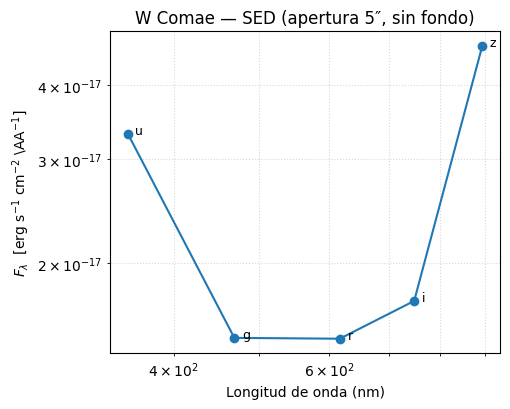

Figura SED guardada en: sdss_WComae/WComae_SED.png


In [16]:
# Si faltan librerías, descomenta:
# !pip install photutils astropy numpy matplotlib pandas

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import proj_plane_pixel_scales
from astropy import units as u
from photutils.aperture import CircularAperture, aperture_photometry

# ---------- Parámetros ----------
indir = Path("sdss_WComae")
bands = ["u", "g", "r", "i", "z"]
lambda_nm = {"u":355.1, "g":468.6, "r":616.5, "i":748.1, "z":893.1}  # nm
pos = SkyCoord(185.382049*u.deg, 28.232894*u.deg, frame="icrs")
radius = 5.0 * u.arcsec

# Conversión (sistema AB): 1 nanomaggie = 3.631e-29 erg s^-1 cm^-2 Hz^-1
NMAGGY_TO_CGS = 3.631e-29
c = 2.99792458e10  # cm/s

def fnu_to_flambda(Fnu_cgs, lam_nm):
    lam_cm = lam_nm * 1e-7    # nm -> cm
    Fl_cm = Fnu_cgs * c / (lam_cm**2)   # erg s^-1 cm^-2 cm^-1
    return Fl_cm / 1e8        # -> erg s^-1 cm^-2 Å^-1

def aperture_flux_cgs(fits_path, skycoord, radius_arcsec, lam_nm):
    hdu = fits.open(fits_path)[0]
    data = hdu.data
    wcs  = WCS(hdu.header)

    # centro y tamaño de apertura en pixeles
    x, y = wcs.world_to_pixel(skycoord)
    pix_deg = np.mean(proj_plane_pixel_scales(wcs))
    pix_as  = pix_deg * 3600.0
    r_pix   = radius_arcsec.to_value(u.arcsec) / pix_as

    ap = CircularAperture((x, y), r=r_pix)
    phot = aperture_photometry(data, ap, method="exact")
    counts = float(phot["aperture_sum"])

    # Calibración: NMGY (nMgy/count) o BUNIT=nanomaggies
    nMgy_fac = hdu.header.get("NMGY", None)
    bunit = (hdu.header.get("BUNIT", "") or "").lower()

    if nMgy_fac is not None:
        nMgy = counts * float(nMgy_fac)
        calib = f"NMGY={nMgy_fac:g} nMgy/count"
    elif "nanomagg" in bunit:
        nMgy = counts
        calib = "BUNIT=nanomaggies"
    else:
        raise RuntimeError(f"{fits_path.name}: falta NMGY/BUNIT=nanomaggies")

    Fnu = nMgy * NMAGGY_TO_CGS
    Fl  = fnu_to_flambda(Fnu, lam_nm)
    return counts, nMgy, Fnu, Fl

# ---------- Calcula flujos ----------
rows = []
for b in bands:
    fp = indir / f"WComae_{b}.fits"
    counts, nMgy, Fnu, Fl = aperture_flux_cgs(fp, pos, radius, lambda_nm[b])
    rows.append({
        "band": b,
        "lambda_nm": lambda_nm[b],
        "counts_sum": counts,
        "flux_nMgy": nMgy,
        "Fnu_cgs": Fnu,               # erg s^-1 cm^-2 Hz^-1
        "Flambda_cgs_per_A": Fl       # erg s^-1 cm^-2 Å^-1
    })

df = pd.DataFrame(rows).sort_values("lambda_nm")
csv_path = indir / "WComae_SED.csv"
df.to_csv(csv_path, index=False)
print("Tabla SED guardada en:", csv_path)

# ---------- Gráfica SED ----------
# Puedes graficar F_nu(λ) o F_λ(λ). Aquí muestro F_λ vs λ (más común en óptico).
x = df["lambda_nm"].values
y = df["Flambda_cgs_per_A"].values

plt.figure(figsize=(5.2,4.2))
plt.loglog(x, y, marker="o")
for xi, yi, b in zip(x, y, df["band"]):
    plt.text(xi*1.02, yi, b, fontsize=9)

plt.xlabel("Longitud de onda (nm)")
plt.ylabel(r"$F_\lambda$  [erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]")
plt.title("W Comae — SED (apertura 5″, sin fondo)")
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.tight_layout()
png_path = indir / "WComae_SED.png"
plt.savefig(png_path, dpi=200)
plt.show()
print("Figura SED guardada en:", png_path)
